<a href="https://colab.research.google.com/github/Simo56a0/embedded-group10/blob/main/EDA_on_Dataset_ASL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wr
import os
import cv2

wr.filterwarnings('ignore')

In [2]:
from google.colab import drive
import os

In [3]:
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
dataset_path = "/content/drive/MyDrive/Dataset ASL Hand Gestures"
folders = os.listdir(dataset_path)

data = []

# Iterate through folders
for folder in folders:
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        # Iterate through each image/video in the folder
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)

            # Check if file is an image or video
            if file.endswith('.jpg') or file.endswith('.png'):
                # Load image, convert to grayscale (if needed), and flatten
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (64, 64))  # Resize for consistency
                img_data = img.flatten()

                # Add to data list
                data.append([file, folder, 'image', img_data])

            elif file.endswith('.mp4') or file.endswith('.avi'):
                # If it's a video, you can extract frames (or use other video features)
                # For simplicity, we can just extract the first frame of the video
                video = cv2.VideoCapture(file_path)
                ret, frame = video.read()
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                frame = cv2.resize(frame, (64, 64))  # Resize
                frame_data = frame.flatten()

                # Add to data list
                data.append([file, folder, 'video', frame_data])

# Convert the data to a DataFrame
df = pd.DataFrame(data, columns=['file_name', 'label', 'file_type', 'data'])

# You can also split the flattened data into separate columns if needed
# For example, flatten the image data into multiple columns
image_data_df = pd.DataFrame(df['data'].tolist())
df = pd.concat([df, image_data_df], axis=1)

In [7]:
# Save the DataFrame to a CSV file
df.to_csv('/content/drive/MyDrive/sign_language_metadata.csv', index=False)


In [8]:
df = pd.read_csv('/content/drive/MyDrive/sign_language_metadata.csv')

In [9]:
# Basic overview of the dataset
df.info()

# Display the first few rows of the dataset
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6912 entries, 0 to 6911
Columns: 4100 entries, file_name to 4095
dtypes: int64(4096), object(4)
memory usage: 216.2+ MB


,file_name,label,file_type,data,0,1,2,3,4,5,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,g_5.avi,Original videos,video,[144 144 144 ... 9 12 15],144,144,144,144,145,145,...,3,3,5,5,10,10,8,9,12,15
1,h_8.avi,Original videos,video,[169 170 170 ... 3 3 4],169,170,170,170,170,171,...,3,3,5,5,4,4,4,3,3,4
2,d_8.avi,Original videos,video,[170 169 169 ... 163 163 164],170,169,169,169,169,170,...,160,162,162,162,163,163,163,163,163,164
3,e_8.avi,Original videos,video,[169 169 169 ... 163 163 163],169,169,169,170,170,170,...,160,162,162,162,162,163,163,163,163,163
4,b_7.avi,Original videos,video,[182 182 182 ... 47 31 34],182,182,182,184,184,184,...,173,172,170,163,57,66,61,47,31,34


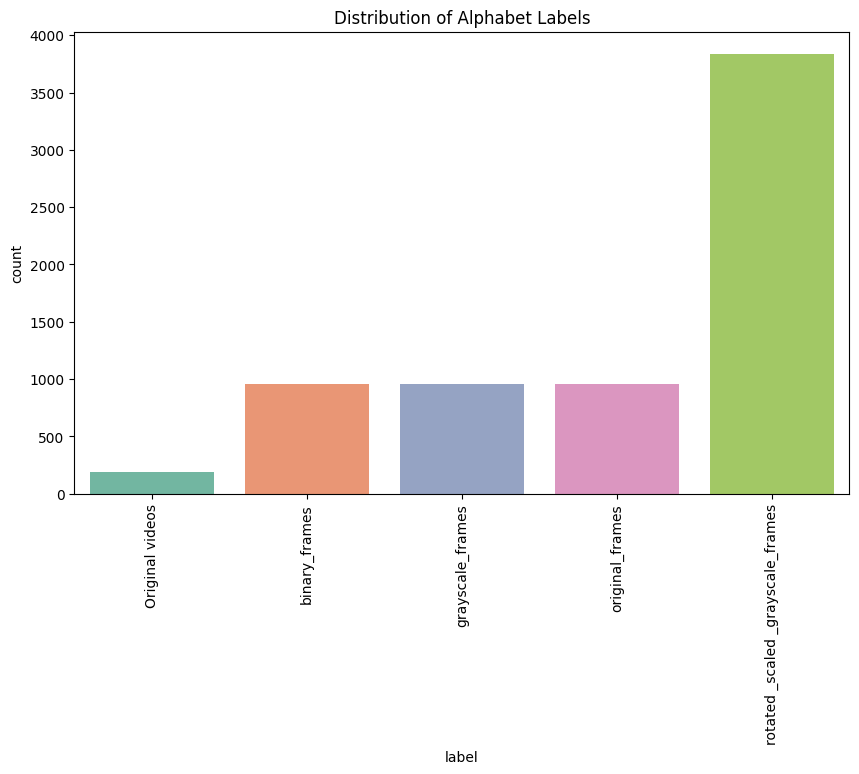

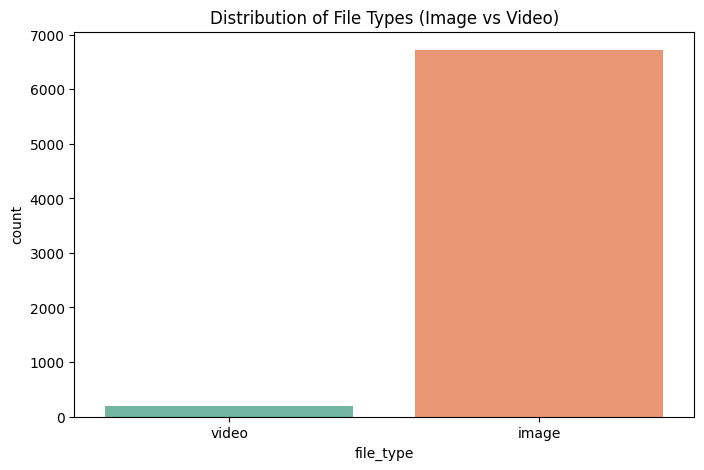

In [10]:
plt.figure(figsize=(10,6))
sns.countplot(x='label', data=df, palette="Set2")
plt.title("Distribution of Alphabet Labels")
plt.xticks(rotation=90)
plt.show()

# Distribution of 'file_type' (image vs video)
plt.figure(figsize=(8,5))
sns.countplot(x='file_type', data=df, palette="Set2")
plt.title("Distribution of File Types (Image vs Video)")
plt.show()

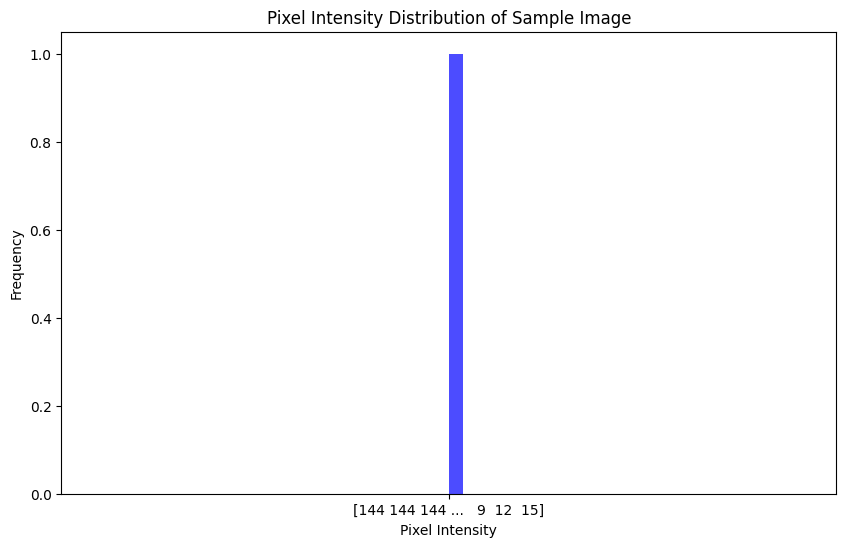

In [11]:
# Plot histogram of pixel values for a sample image
sample_image_data = df.iloc[0]['data']
plt.figure(figsize=(10, 6))
plt.hist(sample_image_data, bins=50, alpha=0.7, color='blue')
plt.title('Pixel Intensity Distribution of Sample Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()


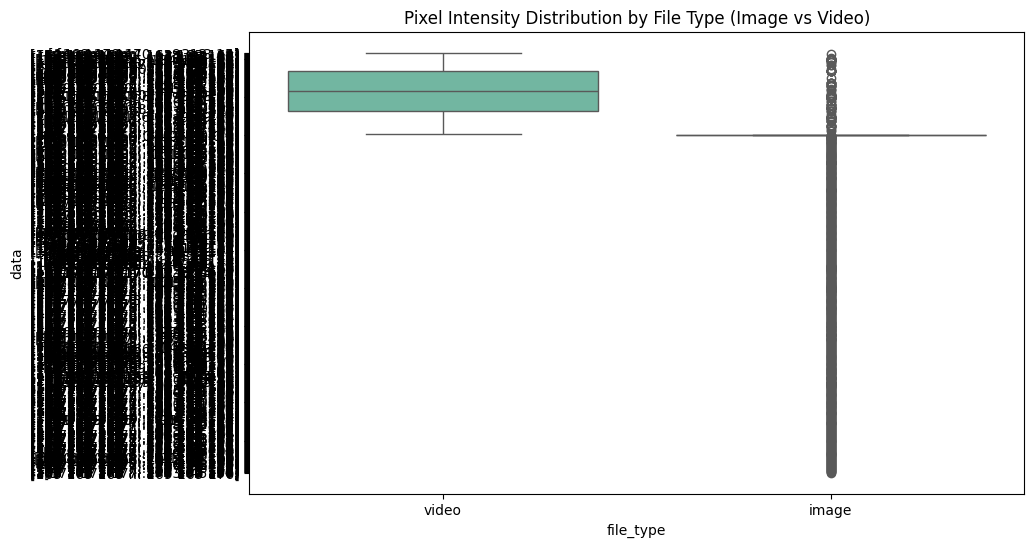

In [12]:
# Compare pixel intensity between image and video file types
plt.figure(figsize=(10, 6))
sns.boxplot(x='file_type', y='data', data=df, palette="Set2")
plt.title("Pixel Intensity Distribution by File Type (Image vs Video)")
plt.show()


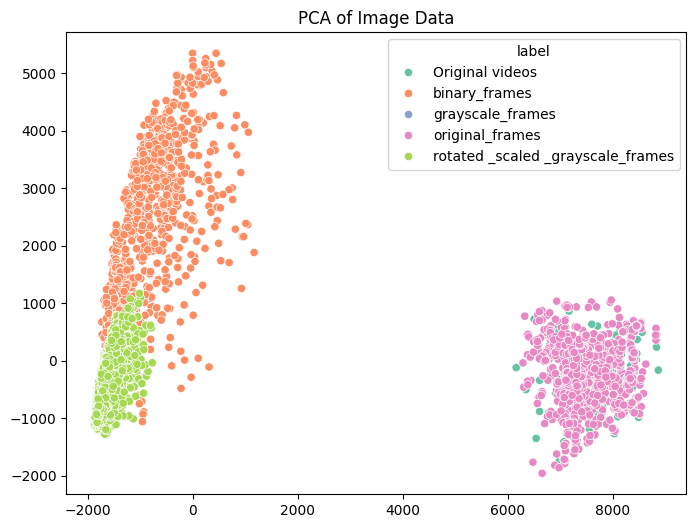

In [13]:
from sklearn.decomposition import PCA

# Apply PCA to reduce to 2 components
pca = PCA(n_components=2)
pca_features = pca.fit_transform(df.iloc[:, 4:])  # Assuming columns 4 onward are pixel data

# Scatter plot of PCA results
plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=df['label'], palette='Set2')
plt.title('PCA of Image Data')
plt.show()


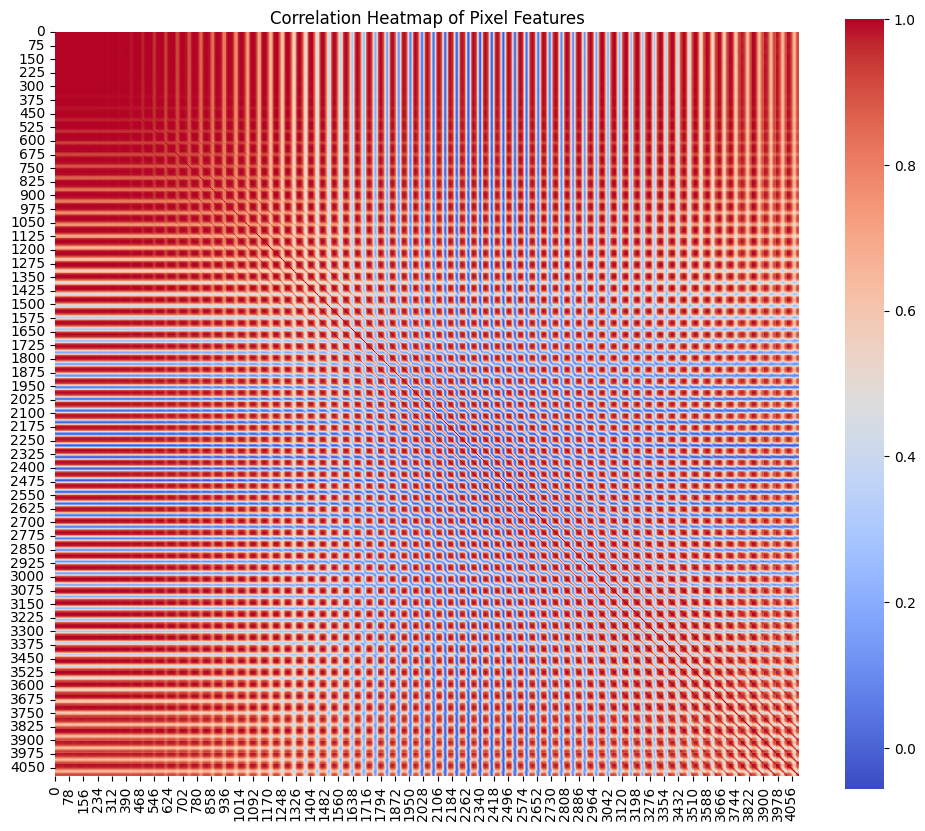

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix (between pixel features)
corr = df.iloc[:, 4:].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt='.2f', square=True)
plt.title('Correlation Heatmap of Pixel Features')
plt.show()


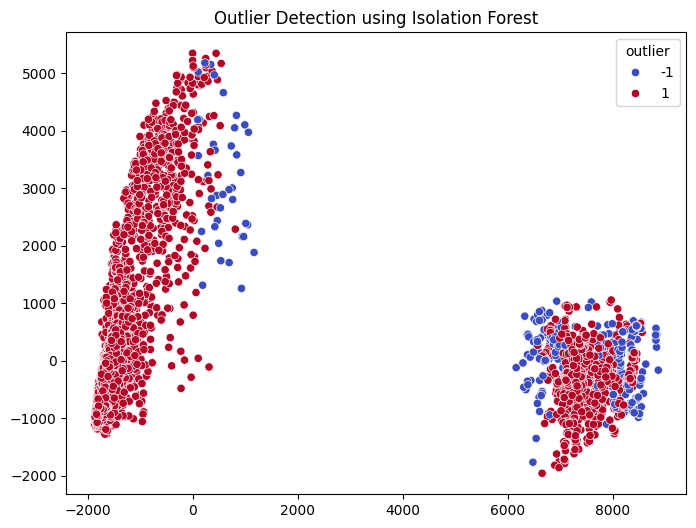

In [15]:
from sklearn.ensemble import IsolationForest

# Apply IsolationForest for outlier detection
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_labels = iso_forest.fit_predict(df.iloc[:, 4:])

# Add outlier labels to the DataFrame
df['outlier'] = outlier_labels

# Visualize outliers
plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=df['outlier'], palette='coolwarm')
plt.title('Outlier Detection using Isolation Forest')
plt.show()
